Reference for model stacking: https://www.kaggle.com/zhixinzhang/stacked-regressions-top-4-on-leaderboard

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
#from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

#import xgboost as xgb
import lightgbm as lgb
import datetime

Using TensorFlow backend.


In [127]:
def diagnostic_stats(ytrue, ypred):
    """
    https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression
    
    https://www.sciencedirect.com/topics/engineering/mean-bias-error
    """
    n = len(ytrue)

    # Check that the ytrue and ypred are equal length vector.
    assert n == len(ypred)
    
    # sum squared error
    sse = np.sum((ytrue - ypred)**2)
    
    # root mean square error
    rmse = np.sqrt(sse/n)

    # total sum of squares
    tss = np.sum((ytrue - np.mean(ytrue))**2)
    tst = np.sum((ypred - np.mean(ypred))**2)
    tstp = tst**0.5
    tssp = tss**0.5
    
    soorat = np.sum((ytrue-np.mean(ytrue))*(ypred-np.mean(ypred)))
    
    # Rsquare
    ##rsqr = 1 - sse/tss
    rsqr = (soorat/(tssp*tstp))**2

    # Mean biased error
    mbe = np.mean(ytrue - ypred)
    
    
    # IOAD
    num = np.sum((ytrue - ypred)**2)
    denom = np.abs(ytrue - ypred) + np.abs(ytrue + ypred)
    ioad = 1 - num/np.sum(denom**2)

    print("RMSE: %1.3f, R^2: %1.3f, MBE: %1.3f, IOAD: %1.3f"%(rmse, rsqr, mbe, ioad))
    
    return rmse, rsqr, mbe, ioad

In [146]:
df = pd.read_csv('rnn_data_prajwal.csv', parse_dates=['DateTime'], index_col='DateTime')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [147]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 01:00:00'), Timestamp('2014-01-01 00:00:00'))

In [148]:
Xvar = ['Ta', 'Ws', 'Fg', 'VPD', 'Fn', 'q', 'Ts', 'Sws']
yvar = 'Fc'

### Train-test splits
    1. Test: 60 days starting randomly picked date
    2. Train: Remaining data
        a. Layer 1 and Layer 2: 50:50 random split
        b. Layer 1 further divided into 1/m unique train sets, where m = number of unique models. 

In [149]:
# Test data set
# 60 days window starting from randomly picked day.
np.random.seed(41)
test_start_day = np.random.choice(df.index.date, 1)[0]
test_end_day = test_start_day + datetime.timedelta(days=60)
print('Test start date:', test_start_day)
print('Test end date:', test_end_day)

Test start date: 2013-03-21
Test end date: 2013-05-20


In [162]:
df_test = df.loc[test_start_day:test_end_day].copy()
df_train = pd.concat([df.loc[:test_start_day], df.loc[test_end_day:]]).copy()

# Scaling test frame
y_test_mean, y_test_std = df_test[yvar].mean(), df_test[yvar].std()
scaler_test = StandardScaler()
df_test[df_test.keys()] = scaler_test.fit_transform(df_test)

# Scaling train frame
scaler_train = StandardScaler()
df_train[df_train.keys()] = scaler_train.fit_transform(df_train)

In [151]:
print(df.loc[test_start_day:test_end_day].index.min(), '>', df.loc[:test_start_day].index.max())
print(df.loc[test_start_day:test_end_day].index.max(), '<',df.loc[test_end_day:].index.min())

assert df.loc[test_start_day:test_end_day].index.min() > df.loc[:test_start_day].index.max()
assert df.loc[test_start_day:test_end_day].index.max() < df.loc[test_end_day:].index.min()

2013-03-21 02:30:00 > 2013-03-20 21:00:00
2013-05-19 20:30:00 < 2013-05-20 06:00:00


In [152]:
X_test, y_test = df_test[Xvar], df_test[yvar]

In [153]:
X_train_layer1, X_train_layer2, y_train_layer1, y_train_layer2 = train_test_split(df_train[Xvar], df_train[yvar], 
                                                                                  test_size=0.50, random_state=40,
                                                                                  shuffle=True)

X_train1_layer1, X_rest1_layer1, y_train1_layer1, y_rest1_layer1 = train_test_split(X_train_layer1, y_train_layer1, test_size=5/6., random_state=1, shuffle=True)
X_train2_layer1, X_rest2_layer1, y_train2_layer1, y_rest2_layer1 = train_test_split(X_rest1_layer1, y_rest1_layer1, test_size=4/5., random_state=1, shuffle=True)
X_train3_layer1, X_rest3_layer1, y_train3_layer1, y_rest3_layer1 = train_test_split(X_rest2_layer1, y_rest2_layer1, test_size=3/4., random_state=1, shuffle=True)
X_train4_layer1, X_rest4_layer1, y_train4_layer1, y_rest4_layer1 = train_test_split(X_rest3_layer1, y_rest3_layer1, test_size=2/3., random_state=1, shuffle=True)
X_train5_layer1, X_train6_layer1,y_train5_layer1,y_train6_layer1 = train_test_split(X_rest4_layer1, y_rest4_layer1, test_size=1/2., random_state=1, shuffle=True)

In [154]:
print('Full', df.shape[0], '-->', 'Test:', df_test.shape[0], 'Train:', df_train.shape[0], '-->',
      'Train layer1: ', X_train_layer2.shape[0], 'Train layer2: ', X_train_layer1.shape[0]),
print('Train layer1 model splits: ', X_train1_layer1.shape[0], X_train2_layer1.shape[0], X_train3_layer1.shape[0], 
      X_train4_layer1.shape[0], X_train5_layer1.shape[0], X_train6_layer1.shape[0])

Full 9015 --> Test: 1367 Train: 7648 --> Train layer1:  3824 Train layer2:  3824
Train layer1 model splits:  637 637 637 637 638 638


In [14]:
#Validation function
def rmsle_cv(model, X_train, y_train, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Layer 1 training

In [15]:
N_FOLDS = 5

##### 1a. Gradient Boosting Regression

In [16]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb, X_train1_layer1, y_train1_layer1, N_FOLDS)
print("\nLightGBM score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

model_lgb.fit(X_train1_layer1, y_train1_layer1);


LightGBM score: 0.8151 (+/-0.1406)



In [17]:
##### 1b. XGBoost
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
#                              learning_rate=0.05, max_depth=6, 
#                              min_child_weight=1.5, n_estimators=7200,
#                              reg_alpha=0.9, reg_lambda=0.6,
#                              subsample=0.2,seed=42, silent=1,
#                              random_state =7)
# score = rmsle_cv(model_xgb, X_train, y_train, N_FOLDS)
# print("\nXGBoost score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

##### 2. LASSO Regression

In [18]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(model_lasso, X_train2_layer1, y_train2_layer1, N_FOLDS)
print("\nLasso score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_lasso.fit(X_train2_layer1, y_train2_layer1);


Lasso score: 0.6596 (+/-0.1064)



##### 3. Random Forest Estimator 

In [19]:
model_rfe = RandomForestRegressor(n_estimators=500, criterion='mse', 
                            max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=2)
score = rmsle_cv(model_rfe, X_train3_layer1, y_train3_layer1, N_FOLDS)
print("\n Random Forest score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_rfe.fit(X_train3_layer1, y_train3_layer1);


 Random Forest score: 0.6193 (+/-0.1264)



##### 4. SVM

In [20]:
model_svm = SVR(kernel='rbf', degree=3, gamma='scale', tol=1e-3, C=1.0, epsilon=0.2)
score = rmsle_cv(model_svm, X_train4_layer1, y_train4_layer1, N_FOLDS)
print("\n Support Vector Reg: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))
model_svm.fit(X_train4_layer1, y_train4_layer1);


 Support Vector Reg: 0.7838 (+/-0.2168)



##### 5. Gaussian Process

In [21]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel=None
model_gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=2)
score = rmsle_cv(model_gp, X_train5_layer1, y_train5_layer1, N_FOLDS)
print("\n Gaussian Process Reg: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

model_gp.fit(X_train5_layer1, y_train5_layer1);


 Gaussian Process Reg: 0.9975 (+/-0.0502)



##### 6. Deep Learning

In [22]:
# define wider model
def dl_model():
    # Create model
    model = Sequential()
    model.add(Dense(15, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

model_dl = KerasRegressor(dl_model, epochs=100, batch_size=500, verbose=0)
score = rmsle_cv(model_dl, X_train6_layer1, y_train6_layer1, N_FOLDS)
print("\n Deep learning: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

model_dl.fit(X_train6_layer1, y_train6_layer1);



 Deep learning: 0.6971 (+/-0.1402)



##### Predictions using layer 1 models for layer 2 data

In [71]:
y_pred1_layer2 = model_lgb.predict(X_train_layer2)
y_pred2_layer2 = model_lasso.predict(X_train_layer2)
y_pred3_layer2 = model_rfe.predict(X_train_layer2)
y_pred4_layer2 = model_svm.predict(X_train_layer2)
y_pred5_layer2 = model_gp.predict(X_train_layer2)
#y_pred6_layer2 = model_dl.predict(X_train_layer2)


y_pred1_test = model_lgb.predict(X_test)
y_pred2_test = model_lasso.predict(X_test)
y_pred3_test = model_rfe.predict(X_test)
y_pred4_test = model_svm.predict(X_test)
y_pred5_test = model_gp.predict(X_test)
#y_pred6_test = model_dl.predict(X_test)

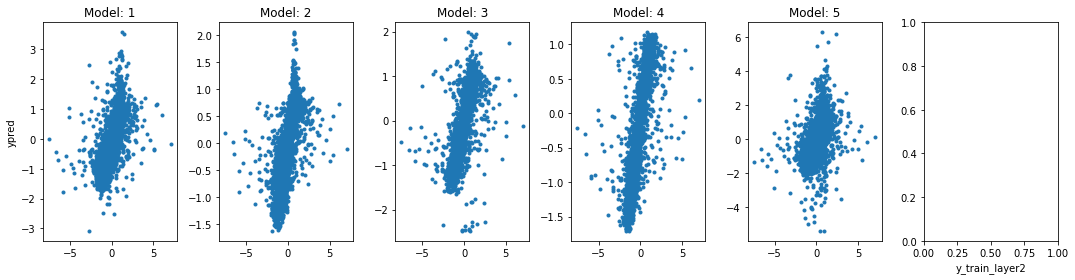

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,4))
for i, preds in enumerate([y_pred1_layer2, y_pred2_layer2, 
                           y_pred3_layer2, y_pred4_layer2, 
                           y_pred5_layer2]):
    ax[i].plot(y_train_layer2, preds, '.')
    ax[i].set_title('Model: {0}'.format(i+1))
ax[0].set_ylabel('ypred')
plt.xlabel('y_train_layer2')
plt.tight_layout()

### Layer 2 training

In [73]:
# Train data
Yfeatures_train_layer2 = pd.DataFrame(np.array([y_pred1_layer2.squeeze(), y_pred2_layer2.squeeze(),
                                   y_pred3_layer2.squeeze(), y_pred4_layer2.squeeze(),
                                   y_pred5_layer2.squeeze()]).T)
Yfeatures_train_layer2.shape, y_train_layer2.shape

((3824, 5), (3824,))

In [74]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

##### Training on layer 2 (Yfeatures(Layer1 Model(X)), y_train) 

In [75]:
# model_layer2_rfe = RandomForestRegressor(n_estimators=500, criterion='mse', 
#                                          max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=2)
# score = rmsle_cv(model_layer2_rfe, Yfeatures_train_layer2, y_train_layer2, N_FOLDS)
# print("\n Random Forest score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

In [114]:
def acc_model(params):
    clf = RandomForestRegressor(**params)
    return cross_val_score(clf, Yfeatures_train_layer2, y_train_layer2, cv=N_FOLDS, scoring="neg_mean_squared_error").mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'n_estimators': hp.choice('n_estimators', range(100,500)), 
    'min_samples_split': hp.choice('min_samples_split', range(2,10)), 
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1,10))}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params, acc)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_1 = fmin(f, param_space, algo=tpe.suggest, max_evals=15, trials=trials)
print ('best:')
print (best_1)

new best:                                             
0                                                     
{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 330}
new best:                                                                       
0                                                                               
{'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 488}
new best:                                                                        
0                                                                                
{'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 276}
new best:                                                                        
0                                                                                
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 367}
new best:                                                

##### Training directly on layer 2 (X_train, y_train)

In [77]:
# model_layer2_rfe = RandomForestRegressor(n_estimators=500, criterion='mse', 
#                                   max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=2)
# score = rmsle_cv(model_layer2_rfe, X_train_layer2, y_train_layer2, N_FOLDS)
# print("\n Random Forest score: {:.4f} (+/-{:.4f})\n".format(score.mean(), score.std()))

In [115]:
def acc_model(params):
    clf = RandomForestRegressor(**params)
    return cross_val_score(clf, X_train_layer2, y_train_layer2, cv=N_FOLDS, scoring="neg_mean_squared_error").mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'n_estimators': hp.choice('n_estimators', range(100,500)), 
    'min_samples_split': hp.choice('min_samples_split', range(2,10)), 
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1,10))}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best_2 = fmin(f, param_space, algo=tpe.suggest, max_evals=15, trials=trials)
print ('best:')
print (best_2)

new best:                                             
0                                                     
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 142}
new best:                                                                       
0                                                                               
{'max_depth': 19, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 479}
new best:                                                                        
0                                                                                
{'max_depth': 15, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 393}
new best:                                                                        
0                                                                                
{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 470}
new best:                                                 

## Test


In [118]:
clf = RandomForestRegressor(max_depth= 5, min_samples_leaf= 9, min_samples_split= 3,n_estimators= 421)
#clf = RandomForestRegressor('max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 3, 'n_estimators': 421)
clf.fit(Yfeatures_train_layer2, y_train_layer2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=9, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=421,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [119]:
Yfeatures_test = pd.DataFrame(np.array([y_pred1_test.squeeze(), y_pred2_test.squeeze(),
                                        y_pred3_test.squeeze(), y_pred4_test.squeeze(),
                                        y_pred5_test.squeeze()]).T)
print(Yfeatures_test.shape, y_test.shape)

(1367, 5) (1367,)


In [120]:
# Test data
clf_single = RandomForestRegressor(**best_2)
clf_single.fit(X_train_layer2, y_train_layer2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=379,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

(-2.024941169353605, 1.6225943629374224)

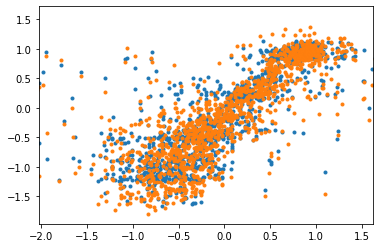

In [121]:
plt.plot(y_test, clf.predict(Yfeatures_test),'.')
plt.plot(y_test, clf_single.predict(X_test),'.')

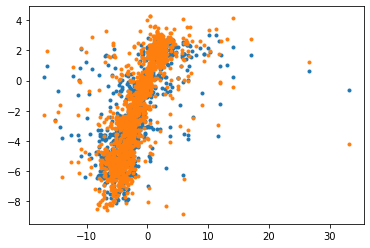

In [167]:
plt.plot(y_test*y_test_std + y_test_mean, clf.predict(Yfeatures_test)*y_test_std + y_test_mean,'.')
plt.plot(y_test*y_test_std + y_test_mean, clf_single.predict(X_test)*y_test_std + y_test_mean,'.')

In [163]:
print('Ensemble')
y_test_pred_ensemble = clf.predict(Yfeatures_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_ensemble*y_test_std + y_test_mean);

Ensemble
RMSE: 2.881, R^2: 0.471, MBE: 0.310, IOAD: 0.906


In [164]:
print('Singe Model')
y_test_pred_single = clf_single.predict(X_test)
diagnostic_stats(y_test*y_test_std + y_test_mean, y_test_pred_single*y_test_std + y_test_mean);

Singe Model
RMSE: 2.930, R^2: 0.461, MBE: 0.267, IOAD: 0.905


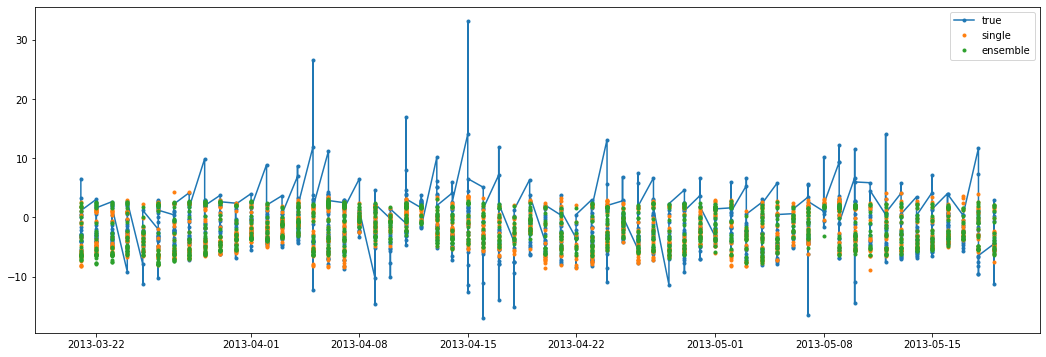

In [184]:
plt.figure(figsize=(18,6))
plt.plot(df_test.index.date, df_test[yvar]*y_test_std + y_test_mean, '.-', label='true')
plt.plot(df_test.index.date, y_test_pred_single*y_test_std + y_test_mean, '.', label='single')
plt.plot(df_test.index.date, y_test_pred_ensemble*y_test_std + y_test_mean, '.', label='ensemble')
plt.legend()

(-5, 5)

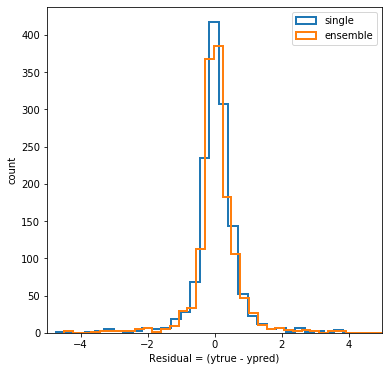

In [196]:
plt.figure(figsize=(6,6))
plt.hist(df_test[yvar] - y_test_pred_single, histtype='step', lw=2, label='single', bins=50)
plt.hist(df_test[yvar] - y_test_pred_ensemble, histtype='step', lw=2, label='ensemble', bins=50)
plt.xlabel('Residual = (ytrue - ypred)')
plt.ylabel('count')
plt.legend()
plt.xlim(-5,5)